# Семинар 6

In [ ]:
import scipy
import numpy as np 
import pandas as pd

import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import matthews_corrcoef

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import KFold, GridSearchCV, train_test_split

## 1. Bias-variance trade-off


Продемонстрируйте bias-variance trade-off на примере DecisionTreeRegressor на представленном датасете, используя функцию plot_regression_predictions и приведенный ниже код (можете модифицировать). 

*Подсказка*: попробуйте несколько значений глубины *max_depth* в пределах от 2 до 10 и сравните с дефолтным None. Также можете попробовать варьировать другие параметры.

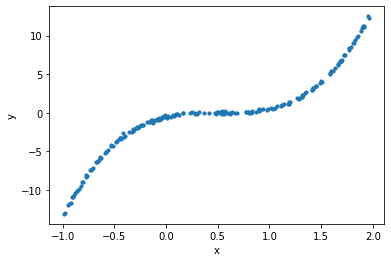

In [ ]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1) * 3 - 1
y = 4 * (X - 0.5) ** 3
y = y + np.random.randn(m, 1) / 10

# визуализируем
plt.scatter(X,y,s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
def plot_regression_predictions(tree_reg, X, y, ax, limits=[0, 1, -1, 1], title=""):
    """Передайте обученное дерево, координаты кривой Х и y, 
        объект ax для отрисовки, опционально - координаты границ
         и заголовок графика"""
    x1 = np.linspace(limits[0], limits[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    ax.axis(limits)
    ax.set_title(title)
    ax.plot(X, y, "b.")
    ax.plot(x1, y_pred, "r.-", alpha=0.1, linewidth=1, label="y")    

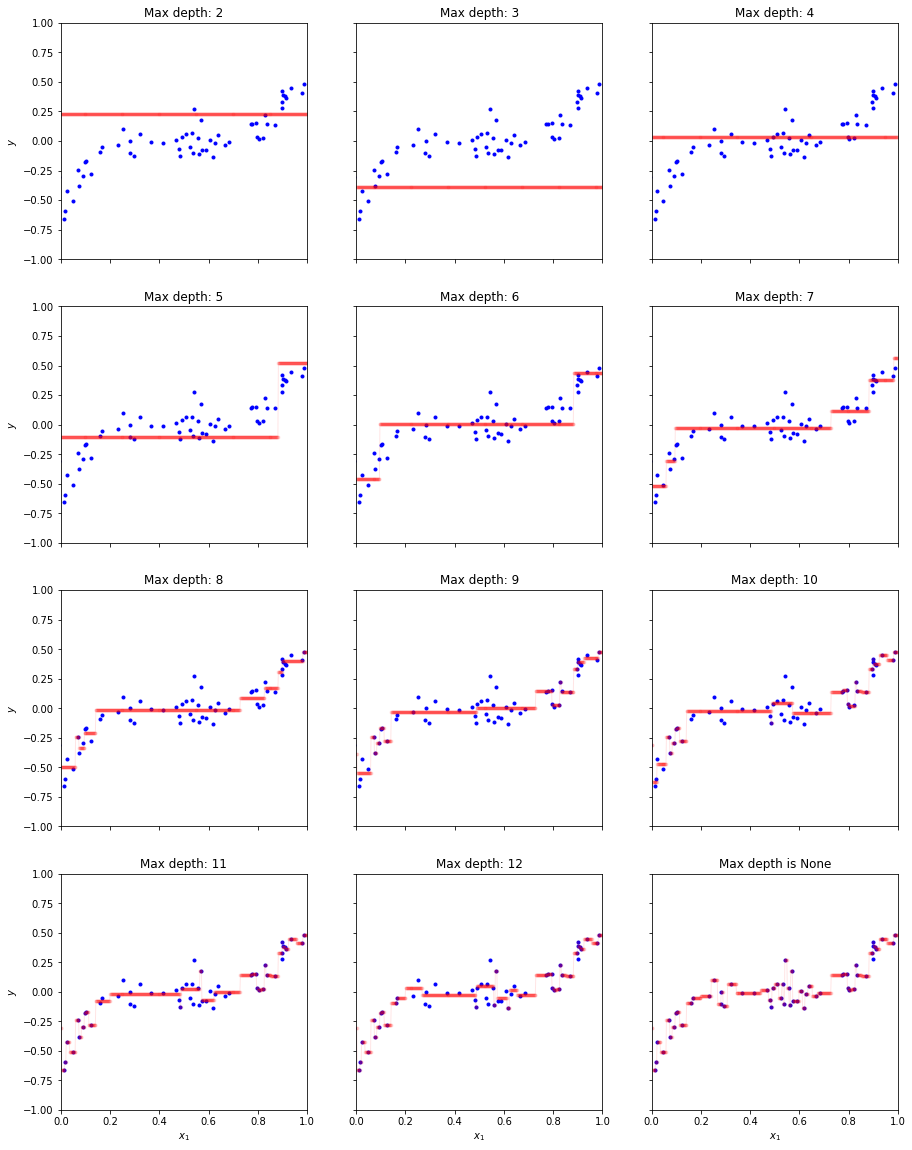

In [ ]:
# Замените "?" рабочим кодом либо напишите полностью свое решение
fig, axes = plt.subplots(4, 3, figsize=(15,20))
axes = axes.flat
max_depth_grid = np.arange(2, 13)

for i, d in enumerate(max_depth_grid):
    axes[i].set(xlabel="$x_1$", ylabel="$y$")
    axes[i].label_outer()
    model = DecisionTreeRegressor(max_depth=d).fit(X, y)
    plot_regression_predictions(model, X, y, axes[i], limits=[0, 1, -1, 1], title=f"Max depth: {d}")

axes[-1].set(xlabel="$x_1$", ylabel="$y$")
axes[-1].label_outer()  
plot_regression_predictions(
    DecisionTreeRegressor(max_depth=None).fit(X, y),
    X, y, axes[-1], limits=[0, 1, -1, 1], title=f"Max depth is {None}"
)

_Посмотрим на ещё один параметр - минимальное количество sample для разделения листа (по умолчанию это 2, делит на 2 листа по 1 sample в каждом)._

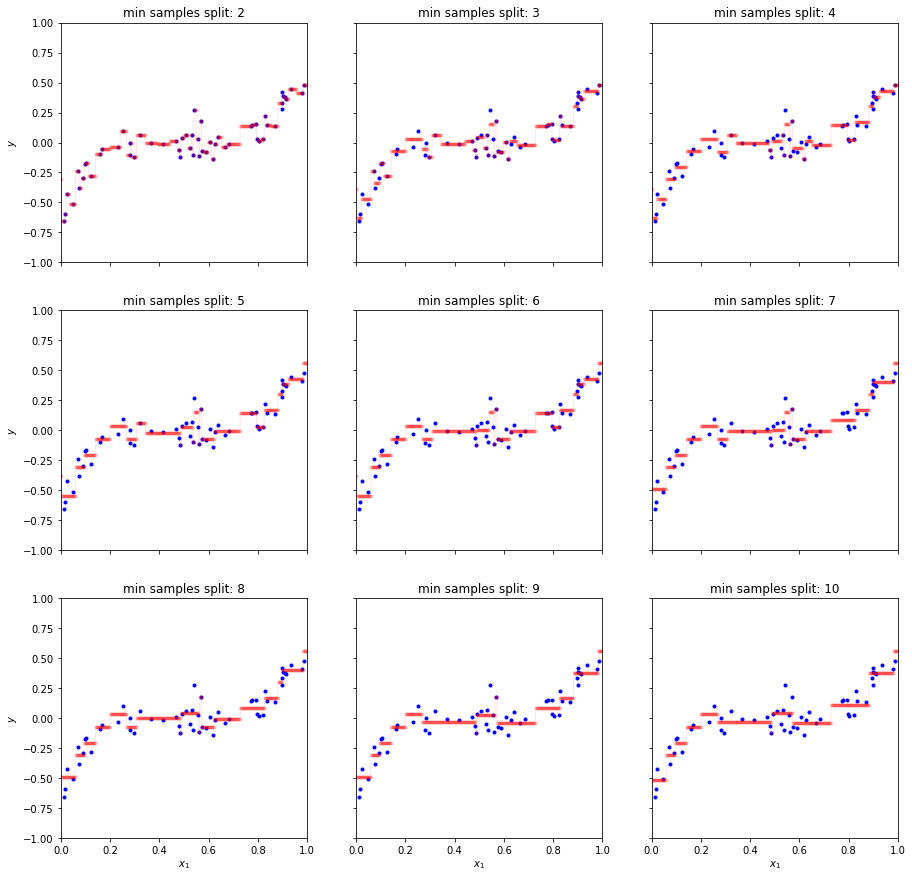

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))
axes = axes.flat
min_samples_split_grid = np.arange(2, 11)

for i, ss in enumerate(min_samples_split_grid):
    axes[i].set(xlabel="$x_1$", ylabel="$y$")
    axes[i].label_outer()
    model = DecisionTreeRegressor(min_samples_split=ss).fit(X, y)
    plot_regression_predictions(model, X, y, axes[i], limits=[0, 1, -1, 1], title=f"min samples split: {ss}")

_При увеличении глубины решающего дерева уменьшается bias (мы приближаем всё лучше, смещение уменьшается), однако растёт variance (дерево всё меньше похоже на прямую линию - разброс увеличивается). Где-то около глубины=9 лежит некоторый оптимум между этими двумя параметрами (в целом искомая зависимость прослеживается, при этом нет обучения по отдельным точкам). При максимальной глубине дерева наблюдается наибольший variance и наименьший bias - наблюдается переобучение дерева._  
_Для min-samples-leaf ситуация обратная - при увеличении снижается variance и увеличивается bias (поскольку мы не даём разделяться некоторым листам). В целом здесь также наблюдается оптимум около значения параметра=9 (большие ставить не имеет значения, поскольку дерево просто недообучится)._

## 2. Качество Bagging с различными базовыми моделями

Попробуем оценить эффект бэггинга на качестве различных моделей классификации: логистической регрессии, SVC и дерева решений.

На датасете *breast_cancer* обучите модели Decision Tree, SVC (с параметрами по умолчанию) и логистическую регрессию.

Полученные предсказания на тесте оцените при помощи корреляции мэтьюса (**sklearn.metrics.matthews_corrcoef**, почитать про пользу этой метрики можно [здесь](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)), построив 90% доверительные интервалы при помощи реализующей bootstrap функции *bootstrap_metric*. Результат отобразите в виде боксплотов.

Обучите **BaggingClassifier** (предварительно почитав [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)) с теми же самыми моделями в качестве базового эстиматора и числом эстиматоров равным 100. 

На новом графике отобразите боксплоты для всех 6 моделей. Сделайте выводы.

In [ ]:
from sklearn.datasets import load_breast_cancer

def bootstrap_metric(x, y,
                    metric_fn,
                    samples_cnt=1000,
                    random_state=777):
    size = len(x)
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val
    
    return b_metric

In [ ]:
breast_cancer = load_breast_cancer()
#print(breast_cancer.DESCR)

In [ ]:
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

Обучите базовые модели и сравните качество:

In [ ]:
logr_model = LogisticRegression(solver='liblinear',\
                                max_iter=1000).fit(X_train, y_train)

dt_model = DecisionTreeClassifier().fit(X_train, y_train)

svc_model = SVC().fit(X_train, y_train)

In [ ]:
dt_pred    =   dt_model.predict(X_test)
svc_pred   =   svc_model.predict(X_test)
logr_pred  =   logr_model.predict(X_test)

In [ ]:
boot_score_dt = bootstrap_metric(y_test,
                                   dt_pred,
                                   metric_fn=lambda x, y: matthews_corrcoef(y_true=x, 
                                                                                  y_pred=y))
boot_score_svc = bootstrap_metric(y_test,
                                   svc_pred,
                                   metric_fn=lambda x, y: matthews_corrcoef(y_true=x, 
                                                                                  y_pred=y))
boot_score_logr = bootstrap_metric(y_test,
                                   logr_pred,
                                   metric_fn=lambda x, y: matthews_corrcoef(y_true=x, 
                                                                                  y_pred=y))

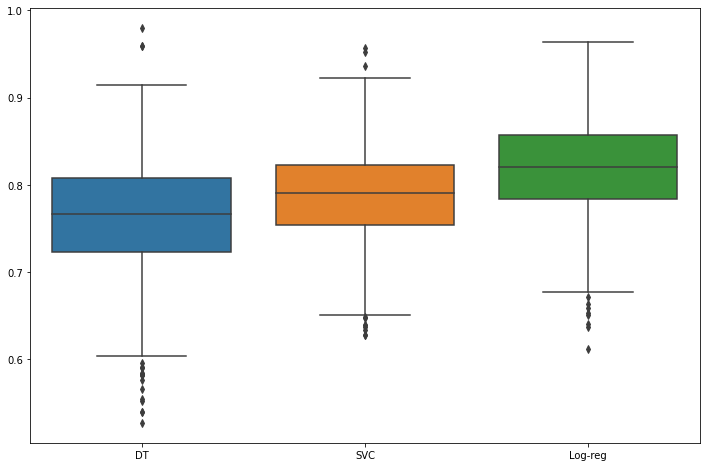

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(y=np.concatenate([boot_score_dt,
                              boot_score_svc, 
                              boot_score_logr]),
             x=["DT"] * 1000 + ['SVC'] * 1000 + ['Log-reg'] * 1000)
plt.show();

Создайте ансамбли BaggingClassifier с рассмотренными выше моделями в качестве базовых эстиматоров и числом эстиматоров равным 100. Получите для каждого из них предсказание и bootstrap-оценку. Добавьте полученные данные на график.

In [ ]:
bagged_svc_model = BaggingClassifier(SVC(), \
                                     n_estimators=100).fit(X_train, y_train)
bagged_logr_model = BaggingClassifier(LogisticRegression(solver='liblinear', max_iter=1000), \
                                      n_estimators=100).fit(X_train, y_train)
bagged_dt_model = BaggingClassifier(DecisionTreeClassifier(), \
                                     n_estimators=100).fit(X_train, y_train)

bagged_dt_pred    =   bagged_dt_model.predict(X_test)
bagged_svc_pred   =   bagged_svc_model.predict(X_test)
bagged_logr_pred  =   bagged_logr_model.predict(X_test)

In [ ]:
bagged_boot_score_dt = bootstrap_metric(y_test,
                                   bagged_dt_pred,
                                   metric_fn=lambda x, y: matthews_corrcoef(y_true=x, 
                                                                                  y_pred=y))
bagged_boot_score_svc = bootstrap_metric(y_test,
                                   bagged_svc_pred,
                                   metric_fn=lambda x, y: matthews_corrcoef(y_true=x, 
                                                                                  y_pred=y))
bagged_boot_score_logr = bootstrap_metric(y_test,
                                   bagged_logr_pred,
                                   metric_fn=lambda x, y: matthews_corrcoef(y_true=x, 
                                                                                  y_pred=y))

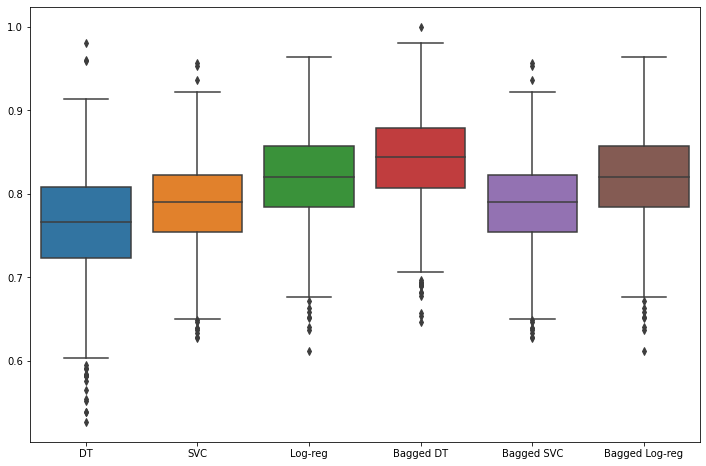

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(y=np.concatenate([boot_score_dt,
                              boot_score_svc, 
                              boot_score_logr,
                              bagged_boot_score_dt,
                              bagged_boot_score_svc,
                              bagged_boot_score_logr]),
             x=["DT"] * 1000 + ['SVC'] * 1000 + ['Log-reg'] * 1000 \
            + ["Bagged DT"] * 1000 + ["Bagged SVC"] * 1000 + ["Bagged Log-reg"] * 1000)
plt.show()

_Видно, что на боксплоте выше уменьшается variance для DT после применения бэггинга (для SVC и Log-reg изменения незначительные). Это можно объяснить тем, что бэггинг понижает variance для решающего дерева, а поскольку само дерево (одно) имеет высокий разброс и зачастую низкое смещение, то на выходе получаем более хорошую модель._

## 3. Древесные модели и работа с признаками.

Поработаем с  [датасетом](https://www.kaggle.com/ronitf/heart-disease-uci), содержащим признаковые описания здоровых людей и пациентов с заболеваниями сердца.

In [ ]:
!gdown  --id 1CFoY_hHBK83u4MQZhAJEEocNC2TYcWTf -O heart.csv 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1CFoY_hHBK83u4MQZhAJEEocNC2TYcWTf 



_Доступа к датасету 20.11.2022 ещё не было, поэтому снизу код не выполнен._



In [ ]:
heart_dataset = pd.read_csv("heart.csv")
print(heart_dataset.shape)
print(heart_dataset.columns.values)
X = heart_dataset.drop("target", axis=1)
y = heart_dataset['target'] > 0
X_train, X_test, y_train, y_test = train_test_split(X, y.values, random_state=777)

(303, 14)
['age' 'sex' 'cp' 'trestbps' 'chol' 'fbs' 'restecg' 'thalach' 'exang'
 'oldpeak' 'slope' 'ca' 'thal' 'target']


In [ ]:
heart_dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


### Эксперимент: обучение классификаторов на вещественных признаках

Качество алгоритмов может зависеть не только от значений гиперпараметров, но и от предобратки исходных признаков. Некоторые из рассмотренных нами алгоритмов чувствительны к масштабу признаков. Посмотрим, насколько различны распределения признаков. Постройте гистограммы для признаков age, trestbps, chol, thalach, oldpeak.

Глядя на получившиеся графики, скажите в чем заключается особенность данных? На какие алгоритмы это может повлиять? Почему?

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12,10))
axes = axes.flat
for i, name in enumerate(['age', 'trestbps', 'chol', 'thalach', 'oldpeak']):
    heart_dataset[name].hist(ax=axes[i])
    axes[i].set_title(name)
fig.tight_layout()

Масштабирование признаков можно выполнить, например, одним из следующих способов:

$x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке;

$x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ —  интервал наблюдаемых значений признака.

Такие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).

Отберите все вещественные признаки и масштабируйте их одним из указанных способов.




In [ ]:
from sklearn.preprocessing import StandardScaler

В этой задаче будем рассматривать алгоритм *RandomForestClassifier*.

Для начала оцените среднее и std качества работы алгоритма с параметрами по умолчанию на масштабированных и исходных вещественных признаках из тренировочной выборки при помощи функции [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). По умолчанию она оценивает качество работы модели по 5 фолдам.


Сделайте вывод о необходимости масштабировать признаки перед подачей их в древесные модели.

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(estimator=RandomForestClassifier(), X=??, y=??)

In [ ]:
# Вывод

### Добавление категориальных признаков в модель

Вспомним, что у нас еще есть категориальные признаки. Случайный лес умеет работать с ними напрямую в том виде, в котором они в датасете находятся сейчас, однако многие другие модели требуют дополнительной предобработки.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)). Передайте в функцию список колонок, которые необходимо закодировать.

После кодирования признаков разбейте датасет заново на тренировочную и тестовую выборки тем же способом, что и раньше.

In [ ]:
heart_dataset_transformed = pd.get_dummies(heart_dataset, columns = [ ??? ])

Обучим случайный лес.

Подберите для него оптимальные значения гиперпараметров, а именно параметр глубины (*max_depth*), критерий разбиения в деревьях (*criterion*) и максимальное число признаков *max_features*.

Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Для ускорения вычислений можете передать параметр *n_jobs = -1*.

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой! Не используйте большие массивы перебираемых значений параметров.

Оцените качество предсказания обученной на всех признаках модели на тесте. Используйте classification_report.

In [ ]:
# Выводы

## 4. Случайный лес и кодирование биологических последовательностей

Сплайсинг $-$ происходящее в ходе процессинга РНК вырезание определённых нуклеотидных последовательностей (интронов) из молекул РНК и соединения оставшихся последовательностей, сохраняющихся в «зрелой» молекуле (экзонов).
Участвующие в процессе сплайсинга белки распознают границы интронов благодаря наличию в последовательности донорных (5') и акцепторных (3') сайтов.

Датасет представляет собой последовательности РНК длиной 60 нуклеотидов, размеченные на 3 класса: содержит донорный сайт, содержит акцепторный сайт, и не содержит таких сайтов.

In [ ]:
!if [ ! -f ./rna_seq.csv ]; then wget https://kodomo.fbb.msu.ru/FBB/year_20/ml/dtrees/rna_seq.csv; fi

--2022-11-20 21:39:50--  https://kodomo.fbb.msu.ru/FBB/year_20/ml/dtrees/rna_seq.csv
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388928 (380K) [text/csv]
Saving to: ‘rna_seq.csv’

rna_seq.csv         100%[===================>] 379.81K   331KB/s    in 1.1s    

2022-11-20 21:39:53 (331 KB/s) - ‘rna_seq.csv’ saved [388928/388928]



Стоблец **class** содержит метки классов:
* 1: Донорный сайт
* 2: Акцепторный сайт
* 3: Не содержит сайтов сплайсинга

Столбцы **B0-B59** содержат последоватедовательности РНК, соотвествующие этим классам.

In [ ]:
 import numpy as np
 import pandas as pd
 pd.set_option('display.max_columns', 999)

 from sklearn.preprocessing import OneHotEncoder
 from sklearn.model_selection import train_test_split
 from sklearn.ensemble import RandomForestClassifier

In [ ]:
data = pd.read_csv("rna_seq.csv")
print(data.shape)
data.head()

(3186, 61)


,class,B0,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,B13,B14,B15,B16,B17,B18,B19,B20,B21,B22,B23,B24,B25,B26,B27,B28,B29,B30,B31,B32,B33,B34,B35,B36,B37,B38,B39,B40,B41,B42,B43,B44,B45,B46,B47,B48,B49,B50,B51,B52,B53,B54,B55,B56,B57,B58,B59
0,3,C,U,A,G,G,C,U,C,C,A,G,A,U,A,G,C,C,A,U,A,G,A,A,G,A,A,C,C,A,A,A,C,A,C,U,U,U,C,U,G,C,G,U,G,U,G,U,G,A,G,A,A,U,A,A,U,C,A,G,A
1,3,G,G,U,G,U,U,G,C,U,C,U,U,A,G,G,A,U,G,U,A,U,C,C,C,C,U,C,A,A,A,C,C,U,A,C,C,U,G,G,U,G,G,U,U,C,U,G,U,G,C,C,U,U,C,C,C,C,U,A,C
2,3,G,G,C,U,G,G,A,C,C,G,A,C,C,A,C,A,G,C,G,C,G,U,G,C,A,G,U,A,A,G,U,C,G,G,C,C,C,C,C,U,G,C,C,C,C,G,U,C,C,U,G,C,C,C,U,G,C,C,G,G
3,1,U,U,C,U,A,U,G,A,G,A,A,A,C,G,U,G,G,C,A,U,U,G,U,G,C,G,C,A,A,G,G,U,G,G,G,C,C,C,C,G,C,G,G,G,A,C,G,G,G,G,C,A,G,C,U,C,C,G,G,G
4,2,C,U,C,C,C,C,A,C,C,C,A,C,C,U,G,U,C,C,A,C,C,C,G,C,C,C,G,C,A,G,A,U,C,G,C,U,U,C,C,U,G,G,A,G,C,C,A,G,G,C,A,A,G,A,A,C,U,C,C,A


In [ ]:
data["class"].value_counts()

3    1654
1     767
2     765
Name: class, dtype: int64

Закодируйте последовательности по следующей схеме:

* A $\rightarrow$ 1 0 0
* C $\rightarrow$ 0 1 0
* G $\rightarrow$ 0 0 1
* U $\rightarrow$ 0 0 0



In [ ]:
y = data["class"]

enc = OneHotEncoder(handle_unknown='error', drop = 60*["U"]) # не заводим для U отдельный признак

X = pd.DataFrame(enc.fit_transform(data.drop("class", axis=1)).toarray()).astype(int)

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0
1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1
4,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3181,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
3182,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0
3183,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,

На 2-3 объектах проверьте, что кодирование прошло успешно.
Дополните словарь и используйте его, чтобы закодировать признаки для этих объектов "вручную", затем сравните с полученным результатом.

In [ ]:
rna_dct = {
    "A": (1, 0, 0),
    "C": (0, 1, 0),
    "G": (0, 0, 1),
    "U": (0, 0, 0),
}

In [ ]:
small_batch = data.drop("class", axis=1).head(3).values

np.all(np.array([ list(map(lambda y: rna_dct[y], x)) for x in small_batch ]).reshape(3,180) == X.iloc[:3, :] )  

True

Создайте и обучите модель случайного леса на подготовленных данных.
Подберите оптимальные параметры *max_features* и *max_depth*.
Качество предсказания оцените при помощи *classification_report* и *matthews_corrcoef*.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

_Построим графики для предварительной оценки (где именно стоит перебирать параметры):_

100%|██████████| 22/22 [00:09<00:00,  2.35it/s]


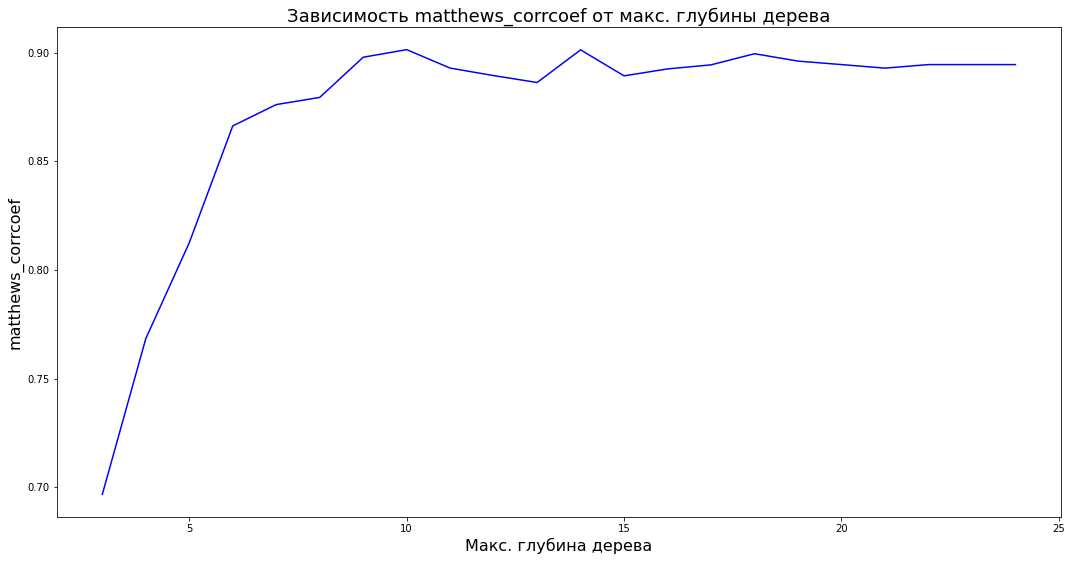

In [ ]:
import tqdm as tqdm
max_depth_range = np.arange(3, 25, 1)
test_scores = np.array([])
plt.figure(figsize=(18, 9))

for i in tqdm.tqdm(range(22)):
    rf = RandomForestClassifier(max_depth=i+3, random_state=0)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    test_scores = np.append(test_scores, matthews_corrcoef(y_test, y_pred_rf))

plt.plot(max_depth_range, test_scores, color='blue')
plt.xlabel('Макс. глубина дерева', fontsize=16)
plt.ylabel('matthews_corrcoef', fontsize=16)
plt.title('Зависимость matthews_corrcoef от макс. глубины дерева', fontsize=18)
plt.show()

100%|██████████| 36/36 [00:40<00:00,  1.12s/it]


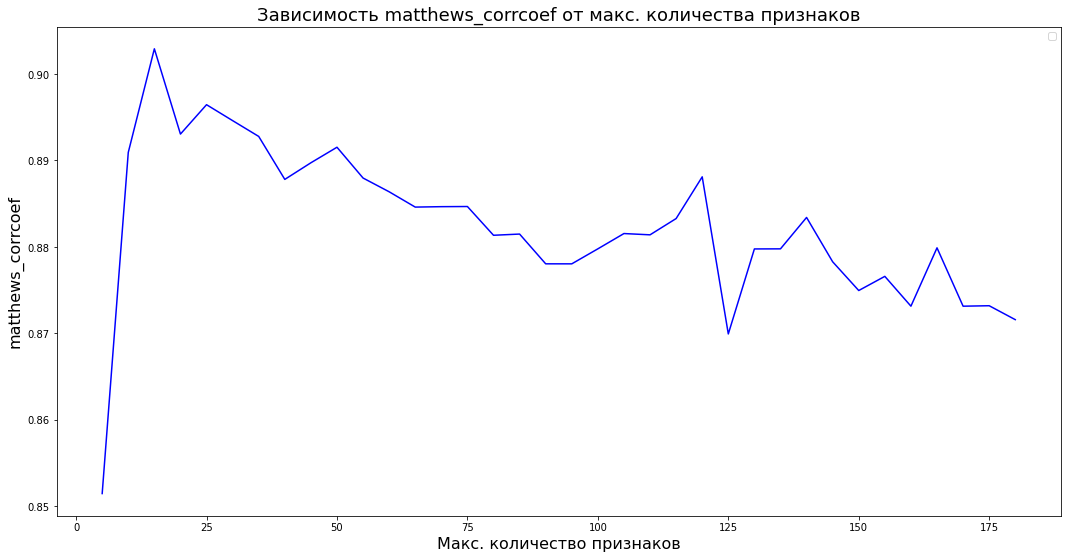

In [ ]:
max_depth_range = np.arange(5, 185, 5)
test_scores = np.array([])
plt.figure(figsize=(18, 9))

for i in tqdm.tqdm(range(1, 37)):
    rf = RandomForestClassifier(max_features=5*i, random_state=0)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    test_scores = np.append(test_scores, matthews_corrcoef(y_test, y_pred_rf))

plt.plot(max_depth_range, test_scores, color='blue')
plt.xlabel('Макс. количество признаков', fontsize=16)
plt.ylabel('matthews_corrcoef', fontsize=16)
plt.title('Зависимость matthews_corrcoef от макс. количества признаков', fontsize=18)
plt.legend()
plt.show()

In [ ]:
gs = GridSearchCV(RandomForestClassifier(), param_grid=
                  {'max_depth': np.arange(9, 16), 
                   'max_features': np.arange(1, 30)}).fit(X_train, y_train)

max_depth, max_features = gs.best_params_['max_depth'], gs.best_params_['max_features']
max_depth, max_features

(15, 19)

In [ ]:
rf_b = RandomForestClassifier(n_estimators=100, max_depth=max_depth, max_features=max_features, random_state=0)
rf_b.fit(X_train, y_train)
y_pred = rf_b.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

In [ ]:
print(f"Matthews correlation coefficient: {matthews_corrcoef(y_test, y_pred):.4f}\n\n")


print(classification_report(y_test, y_pred))

Matthews correlation coefficient: 0.8930


              precision    recall  f1-score   support

           1       0.97      0.88      0.93       248
           2       0.88      0.93      0.91       229
           3       0.94      0.96      0.95       479

    accuracy                           0.93       956
   macro avg       0.93      0.93      0.93       956
weighted avg       0.93      0.93      0.93       956



**Вывод:** _После примерной оценки по коэф-ту корреляции получили приемлемые F1-score на тесте. Примечательно, что при глубине деревьев более 10 коэфф-т сильно не изменяется(что логично, каждое дерево имеет увеличивающийся variance с ростом глубины, однако поскольку деревья независимые, то есть слабо коррелируют друг с другом, то их усреднение понижает variance; в итоге имеет место как малое смещение, так и малый разброс значений - отсюда и высокие значения метрик и коэф-та корреляции), оптимальное число признаков недалеко от корня из количества всех имеющихся признаков (18 на гридсёрче и примерно 13-14, если взять корень)._